# Проект 6. Прогнозирование уровня заработной платы

Целью данной задачи является построение модели **классификации пользователей**: на вход модель будет принимать данные о человеке, а на выходе она должна предсказывать бинарный уровень дохода человека (больше или меньше 50000$ за год).

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#магическая команда, указывает, что графики нужно строить прямо в ноутбуке: 
%matplotlib inline

Ведение наблюдений через Comet

In [93]:
from comet_ml import Experiment
# импорт закрытого ключа
import os
from dotenv import load_dotenv

dotenv_path = os.path.join(os.getcwd(), '.env')
if os.path.exists(dotenv_path):
    load_dotenv(dotenv_path)
# Получение токена из конфигурационного файла
API_COMET = os.environ["API_COMET"]

# Создание эксперимента с помощью вашего API ключа
experiment = Experiment(api_key=API_COMET,
                        project_name='hw-07-predict-income',
                        workspace='al-ogr')

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/al-ogr/hw-07-predict-income/dd887c7051374bc18c3cd5df436b76fc



In [94]:
# считывание данных

traning_data = pd.read_csv('./data/train.csv')
testing_data = pd.read_csv('./data/test.csv')

display(traning_data)
display(testing_data)

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,49,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40,United-States,0
1,27,NaN,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,45,United-States,0
2,44,NaN,11th,Married-civ-spouse,Other-service,Husband,Black,Male,0.0,0.0,60,United-States,0
3,59,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,0.0,0.0,60,United-States,0
4,54,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,0.0,1408.0,38,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24415,47,Private,Bachelors,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40,United-States,0
24416,31,Private,12th,Divorced,Other-service,Unmarried,White,Female,0.0,0.0,21,United-States,0
24417,18,Private,11th,Never-married,Adm-clerical,Own-child,White,Female,0.0,0.0,20,United-States,0
24418,50,Self-emp-not-inc,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,84,United-States,0


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,27,Private,Some-college,Divorced,Adm-clerical,Not-in-family,White,Female,0.0,0.0,38,United-States,0
1,45,State-gov,HS-grad,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40,United-States,0
2,29,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0.0,NaN,55,United-States,1
3,30,Private,Bachelors,Never-married,Machine-op-inspct,Not-in-family,White,Female,0.0,0.0,40,United-States,0
4,29,Self-emp-not-inc,Some-college,Divorced,Craft-repair,Not-in-family,White,Male,2202.0,0.0,50,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8136,35,Private,HS-grad,Separated,Other-service,Not-in-family,Black,Male,0.0,0.0,40,United-States,0
8137,60,Private,5th-6th,Married-civ-spouse,Sales,Husband,White,Male,NaN,0.0,40,?,1
8138,25,?,HS-grad,Never-married,?,Unmarried,Black,Female,0.0,0.0,40,United-States,0
8139,50,Private,Bachelors,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,40,United-States,1


Выделение целевой переменной income:

In [95]:
y_train = traning_data['income']
y_test = testing_data['income']

x_train = traning_data.drop(columns=['income'])
x_test = testing_data.drop(columns=['income'])

Сбалансированность выборки:

In [96]:
display(y_train.value_counts(normalize=True))
display(y_test.value_counts(normalize=True))

income
0    0.757821
1    0.242179
Name: proportion, dtype: float64

income
0    0.763297
1    0.236703
Name: proportion, dtype: float64

Вывод статистики

In [97]:
x_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,24420.0,38.598116,13.638458,17.0,28.0,37.0,48.0,90.0
capital-gain,23705.0,1051.724067,7199.945441,0.0,0.0,0.0,0.0,99999.0
capital-loss,23936.0,88.409592,404.466154,0.0,0.0,0.0,0.0,4356.0
hours-per-week,24420.0,40.386568,12.299621,1.0,40.0,40.0,45.0,99.0


{'web': 'https://www.comet.com/api/image/download?imageId=de7011b2501a463cae201a52da50747c&experimentKey=dd887c7051374bc18c3cd5df436b76fc',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=de7011b2501a463cae201a52da50747c&experimentKey=dd887c7051374bc18c3cd5df436b76fc',
 'imageId': 'de7011b2501a463cae201a52da50747c'}

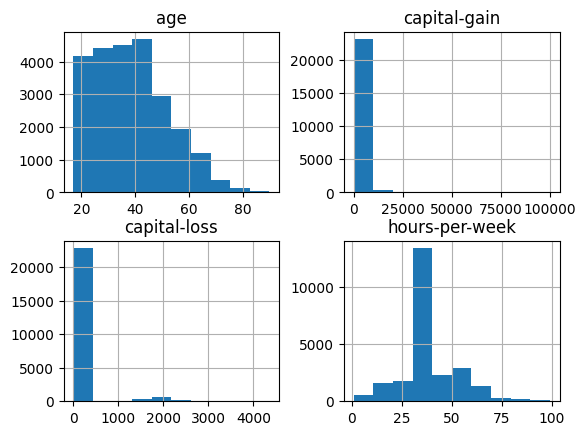

In [98]:
# Отрисовка гистограмм числовых данных и их логирование в эксперименте
x_train.hist()
experiment.log_figure('x_train_numeric_distr', plt)

## Предварительная обработка данных

In [99]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24420 entries, 0 to 24419
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             24420 non-null  int64  
 1   workclass       23223 non-null  object 
 2   education       23443 non-null  object 
 3   marital-status  24420 non-null  object 
 4   occupation      24420 non-null  object 
 5   relationship    24420 non-null  object 
 6   race            24420 non-null  object 
 7   sex             24420 non-null  object 
 8   capital-gain    23705 non-null  float64
 9   capital-loss    23936 non-null  float64
 10  hours-per-week  24420 non-null  int64  
 11  native-country  24420 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 2.2+ MB


In [100]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8141 entries, 0 to 8140
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             8141 non-null   int64  
 1   workclass       7710 non-null   object 
 2   education       7816 non-null   object 
 3   marital-status  8141 non-null   object 
 4   occupation      8141 non-null   object 
 5   relationship    8141 non-null   object 
 6   race            8141 non-null   object 
 7   sex             8141 non-null   object 
 8   capital-gain    7879 non-null   float64
 9   capital-loss    7974 non-null   float64
 10  hours-per-week  8141 non-null   int64  
 11  native-country  8141 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 763.3+ KB


### Обработка пропусков

для capital-gain и capital-loss заполняем наиболее популярными данными - 0

In [101]:
x_train['capital-gain'] = x_train['capital-gain'].fillna(value=0)
x_train['capital-loss'] = x_train['capital-loss'].fillna(value=0)
x_test['capital-gain'] = x_test['capital-gain'].fillna(value=0)
x_test['capital-loss'] = x_test['capital-loss'].fillna(value=0)

Пропуски категориальных данных заполним модами из тренировочной выборки.

In [102]:
x_train['workclass'].mode(), x_train['education'].mode()

(0    Private
 Name: workclass, dtype: object,
 0    HS-grad
 Name: education, dtype: object)

In [103]:
x_train['workclass'] = x_train['workclass'].fillna(value='Private')
x_train['education'] = x_train['education'].fillna(value='HS-grad')
x_test['workclass'] = x_test['workclass'].fillna(value='Private')
x_test['education'] = x_test['education'].fillna(value='HS-grad')

## Кодировка категориальных признаков

In [104]:
categorical_features = ['workclass', 'education', 'marital-status', 
                        'occupation', 'relationship', 'race', 'sex', 
                        'native-country']

non_categorical_features = ['age', 'capital-gain', 'capital-loss', 
                            'hours-per-week']

Посмотрим на столбцы категориальных переменных:

In [105]:
x_train[categorical_features].head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
1,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States
2,Private,11th,Married-civ-spouse,Other-service,Husband,Black,Male,United-States
3,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,United-States
4,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,United-States


Мы рассмотрим два популярных метода кодирования категориальных признаков:
* Label Encoding, которому соответствует класс `LabelEncoder()` из библиотеки **sklearn**
* One Hot Encoding, которому соответствует класс `OneHotEncoder()` из библиотеки **sklearn**

**Label Encoding**



In [106]:
from sklearn.preprocessing import LabelEncoder

In [107]:
label_encoder = LabelEncoder()

In [108]:
x_train_le = x_train.copy()

In [109]:
x_test_le = x_test.copy()

In [110]:
for feature in categorical_features:
    x_train_le[feature] = label_encoder.fit_transform(x_train_le[feature])
    x_test_le[feature] = label_encoder.transform(x_test_le[feature])

In [111]:
x_train_le.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,49,4,11,2,3,0,4,1,0.0,0.0,40,39
1,27,4,11,2,7,0,4,1,0.0,0.0,45,39
2,44,4,1,2,8,0,2,1,0.0,0.0,60,39
3,59,4,9,5,1,4,4,1,0.0,0.0,60,39
4,54,4,9,0,12,1,4,0,0.0,1408.0,38,39


**One Hot Encoding**



In [112]:
from sklearn.preprocessing import OneHotEncoder

In [113]:
onehot_encoder = OneHotEncoder()

In [114]:
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
x_train_onehot = onehot_encoder.fit_transform(x_train[categorical_features]).toarray()

# применяем полученное преобразование к тестовой выборке, результат переводим в массив
x_test_onehot = onehot_encoder.transform(x_test[categorical_features]).toarray()

# запишем полученные названия новых колонок в отдельную переменную
columns = onehot_encoder.get_feature_names_out(categorical_features)

In [115]:
x_train_onehot = pd.DataFrame(x_train_onehot, columns=columns)
x_test_onehot = pd.DataFrame(x_test_onehot, columns=columns)

И наконец, запишем в новую переменную полученный результат, удалив все незакодированные категориальные признаки из новой таблицы. 

In [116]:
# соединяем новую табличку с исходной
x_train_new = pd.concat([x_train, x_train_onehot], axis=1)
x_test_new = pd.concat([x_test, x_test_onehot], axis=1)

# удаляем старые категориальные признаки
x_train_new = x_train_new.drop(columns=categorical_features)
x_test_new = x_test_new.drop(columns=categorical_features)

In [117]:
x_train_new.head()

,age,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,49,0.0,0.0,40,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,27,0.0,0.0,45,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,44,0.0,0.0,60,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,59,0.0,0.0,60,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,54,0.0,1408.0,38,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Обучение модели 

## Выбор метода обучения классификатора

Для обучения классификатора воспользуемся логистической регрессией.
 

In [118]:
from sklearn.linear_model import LogisticRegression

Создаем прототип класса модели:

In [119]:
linear_model = LogisticRegression()
linear_model_oh = LogisticRegression()

## Обучение модели на разных типах закодированных данных

In [120]:
linear_model_oh.fit(x_train_new, y_train)

d:\!Works\Projects\sf_data_science_hw\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [121]:
linear_model.fit(x_train_le, y_train)

d:\!Works\Projects\sf_data_science_hw\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# Валидация модели на тестовой выборке

In [122]:
prediction_oh = linear_model_oh.predict(x_test_new)
prediction_le = linear_model.predict(x_test_le)

In [123]:
np.unique(prediction_oh)

array([0, 1])

In [124]:
# Сколько 1го класса присутсвует в предсказаниях?
pd.DataFrame(prediction_oh).value_counts()

0
0    6573
1    1568
Name: count, dtype: int64

In [125]:
# Сколько 1го класса присутсвует в y_test?
y_test.value_counts()

income
0    6214
1    1927
Name: count, dtype: int64

## Точность предсказания

Посчитаем точность (**accuracy**) работы моделей. Напомним, что точность отражает, сколько в процентном соотношении от размера тестовой выборки модель угадала 1 и сколько угадала 0.

Функция для подсчета точности реализована в библиотеке **sklearn** и называется `accuracy_score()`.

In [126]:
from sklearn.metrics import accuracy_score

In [127]:
acc_oh = accuracy_score(y_test, prediction_oh)
acc_le = accuracy_score(y_test, prediction_le)

In [128]:
experiment.log_metric('Accuracy OneHot data', acc_oh)

In [129]:
acc_oh

0.8505097653850878

Сравним значения точности для наших моделей с точностью для константного классификатора, модели, которая всегда бы предсказывала больший класс, в нашем случае 0. Для этого можно в функцию `accuracy_score()` в качестве второго аргумента передать массив нулей такого же размера. Это делается с помощью функции `zeros_like()` из библиотеки **numpy**.

In [130]:
print(f'Accuracy Major Class: {accuracy_score(y_test, np.zeros_like(y_test)):.3f}')

Accuracy Major Class: 0.763


In [131]:
# Залогировать accuracy для LE
experiment.log_metric('Accuracy LabelEncoding data', acc_le)

In [132]:
acc_le

0.804692298243459

## Таблица сопряженности модели классификации

Другой способ оценивать качество работы классификатора - использовать таблицу сопряженности. 


|                   |  Предсказано `0` |  Предсказано `1` |
|:-------------------|:------------------|:------------------|
|**Фактически** `0`  |       TN         |       FP         |
|**Фактически** `1`  |       FN         |       TP         | 


In [133]:
from sklearn.metrics import confusion_matrix

In [134]:
pd.DataFrame(confusion_matrix(y_test, prediction_oh))

,0,1
0,5785,429
1,788,1139


In [135]:
experiment.log_confusion_matrix(y_test, prediction_oh)

{'web': 'https://www.comet.com/api/asset/download?assetId=44c16b2e08774561b61e915c3d897e12&experimentKey=dd887c7051374bc18c3cd5df436b76fc',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=44c16b2e08774561b61e915c3d897e12&experimentKey=dd887c7051374bc18c3cd5df436b76fc',
 'assetId': '44c16b2e08774561b61e915c3d897e12'}

## Прогноз вероятности принадлежности к классу

In [136]:
pred_proba_oh = linear_model_oh.predict_proba(x_test_new)

In [137]:
# Как выглядят предсказания?
pred_proba_oh

array([[0.95615652, 0.04384348],
       [0.43434882, 0.56565118],
       [0.26241241, 0.73758759],
       ...,
       [0.99716402, 0.00283598],
       [0.37722637, 0.62277363],
       [0.67290153, 0.32709847]], shape=(8141, 2))

In [138]:
pred_proba = pred_proba_oh[:, 1]

Посмотрим на распределение предсказанной классификатором вероятности дохода > 50к, метки `1`.

{'web': 'https://www.comet.com/api/image/download?imageId=1185e2f892d04c74bcb3c37ed71884e3&experimentKey=dd887c7051374bc18c3cd5df436b76fc',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=1185e2f892d04c74bcb3c37ed71884e3&experimentKey=dd887c7051374bc18c3cd5df436b76fc',
 'imageId': '1185e2f892d04c74bcb3c37ed71884e3'}

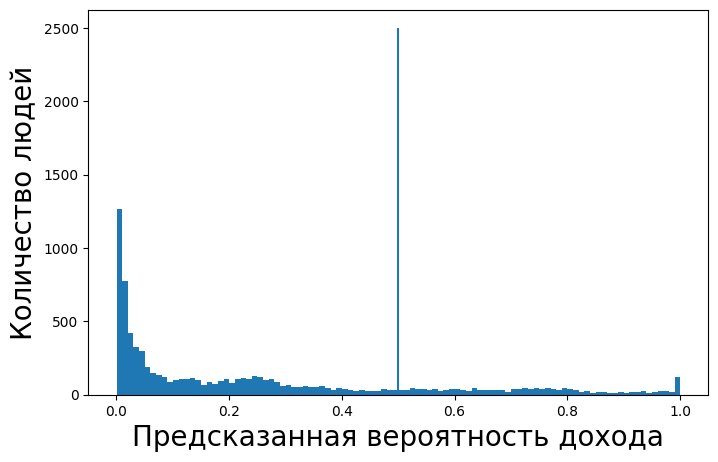

In [139]:
plt.figure(figsize=(8, 5))

plt.hist(pred_proba, bins=100)
plt.vlines(0.5, 0, 2500)

plt.xlabel('Предсказанная вероятность дохода', fontsize=20)
plt.ylabel('Количество людей', fontsize=20)

experiment.log_figure('predicted_income_probability', plt)

## ROC кривая классификатора

Если хотят сравнить метрики на разных наборах данных, обычно работают не с абсолютными значениями True Positive и False Positive, а с их долями:

* Доля ложноположительных срабатываний $\text{FPR} = \frac{FP}{FP + TN}$;
* Доля истинно положительных срабатываний $\text{TPR} = \frac{TP}{TP + FN}$.

Заметим, что $FP + TN$ дает общее число объектов класса $0$, а $TP + FN$ - общее число объектов класса $1$. 

Одной из самых популярных метрик для задачи классификации является ROC кривая. ROC расшифровывается как *Receiver Operating Characteristic*. Эта кривая наглядно показывает зависимость доли истинно позитивных срабатываний (**TPR**) от доли ложно позитивных срабатываний (**FPR**) при изменении порога классификации.

Функция `roc_curve()` из **scikit-learn** позволяет получить координаты точек ROC кривой, а также значения порога `threshold`, при котором достигается соответствующие значения метрик **FPR** и **TPR**.

На вход функции `roc_curve()` необходимо передать два аргумента:
* истинные значения меток
* вероятности, предсказанные моделью

In [140]:
from sklearn.metrics import roc_curve

In [141]:
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, pred_proba)

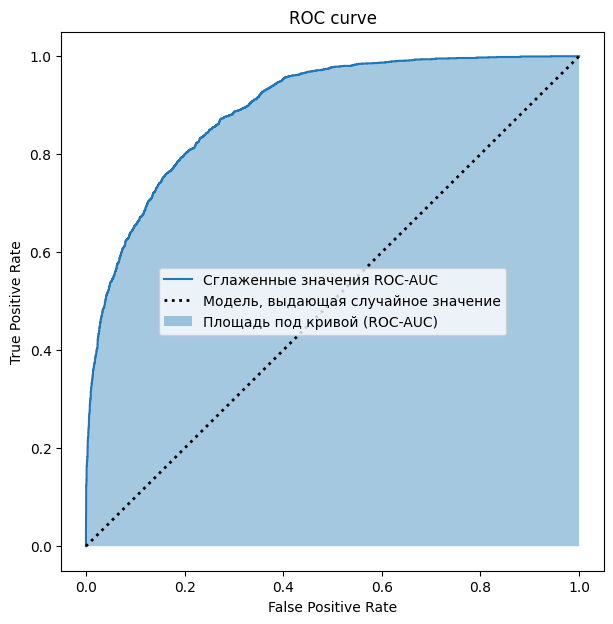

In [142]:
# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, 
         label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step="pre", 
                 alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

In [143]:
from sklearn.metrics import roc_auc_score

In [144]:
roc_auc = roc_auc_score(y_test, pred_proba).round(3)

In [145]:
print("ROC-AUC на тестовой выборке:", roc_auc_score(y_test, pred_proba).round(3)) 

ROC-AUC на тестовой выборке: 0.893


In [146]:
experiment.log_metric('roc_auc OneHot data', roc_auc)

In [147]:
pred_proba_le = linear_model.predict_proba(x_test_le)

In [148]:
pred_proba = pred_proba_le[:, 1]

In [149]:
roc_auc = roc_auc_score(y_test, pred_proba).round(3)
roc_auc

np.float64(0.785)

---

In [150]:
# Завершение эксперимента
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : tan_asp_2854
COMET INFO:     url                   : https://www.comet.com/al-ogr/hw-07-predict-income/dd887c7051374bc18c3cd5df436b76fc
COMET INFO:   Metrics:
COMET INFO:     Accuracy LabelEncoding data : 0.804692298243459
COMET INFO:     Accuracy OneHot data        : 0.8505097653850878
COMET INFO:     roc_auc OneHot data         : 0.893
COMET INFO:   Parameters:
COMET INFO:     C                     : 1.0
COMET INFO:     categories            : auto
COMET INFO:     class_weight          : None
COMET INFO:     drop                  : None
COMET INFO:     dtype                 : <class 'numpy.float64'>
COMET INFO:     dual                  : False
COM